In [1]:
import functools

import numpy as np
from collections import defaultdict
from scipy.special import expit

import pyspark.sql.functions as psf
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.functions import udf, pandas_udf
from pyspark.sql.functions import col
import pyspark.sql as pysql
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, MapType, ArrayType, FloatType, BooleanType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
# from operator import add
# from functools import reduce

pd.set_option('display.max_columns', None)
spark.conf.set('spark.sql.session.timeZone', 'UTC')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
876,application_1657150860135_0877,pyspark,idle,Link,Link,gakumar,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
input_cols = ['tx_ucast_packets', 'rxpkt_rank_pct', 'name', 'num_vlan', 'rx_ucast_root_avg', 
              'tx_mcast_packets', 'site_id', 'hour', 'tx_upkt_rank_pct', 'txpkt_rank_pct', 
              'rx_ucast_packets', 'tx_root_avg', 'rx_mcast_packets', 'rx_upkt_rank_avg', 
              'rxpkt_rank_avg', 'rx_packets', 'tx_bcast_packets', 'rx_root_avg', 
              'rx_bcast_packets', 'tx_rx_root_avg', 'tx_ucast_root_avg', 'remotecap', 'rmbps', 
              'events_count', 'tx_upkt_rank_avg', 'tx_packets', 're_ix', 'physical_port_count', 
              'bridge_port_count', 'switch_id', 'txpkt_rank_avg', 'rx_upkt_rank_pct', 'label', 
              'tx_rx_ucast_root_avg', 'bridge']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
ae_local_s3_path = "s3://mist-data-science-dev/gakumar/uplink/training_data/new_ae_data_20apr/*/*"
old_local_s3_path = "s3://mist-data-science-dev/gakumar/uplink/training_data/new_data_31mar_backup/*/*"
extra_old_local_s3_path = "s3://mist-data-science-dev/gakumar/uplink/training_data/new_data_31mar_extra/*/*"


df_train_old = spark.read.parquet(old_local_s3_path).select(input_cols)
df_train_extra = spark.read.parquet(extra_old_local_s3_path).select(input_cols)
df_train = spark.read.parquet(ae_local_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
df_new = df_train.toPandas()
df_old = df_train_old.toPandas()
df_extra = df_train_extra.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
df_new.shape, df_old.shape, df_extra.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

((199824, 42), (181990, 35), (17829, 35))

In [7]:
df_combined = pd.concat([df_old, df_extra], ignore_index=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
df_combined.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(199819, 35)

# Mixing Data

In [9]:
df_agg_port = df_new.groupby(["site_id", "switch_id", "hour"]).agg({"ae_port": "sum"}).reset_index()
df_agg_port.rename(columns = {"ae_port":"ae_port_count"}, inplace=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
df = df_new.merge(df_agg_port, how="left", on=["site_id", "switch_id", "hour"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# Using events count to normalize data
avg_data_cols_list = ['rx_packets', 'tx_packets', 'rx_ucast_packets', 'tx_ucast_packets', 
                        'rx_bcast_packets', 'tx_bcast_packets']
for col in avg_data_cols_list:
    df[col+"_avg"] = df[col]/df["events_count"]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Index(['switch_id', 'name', 'org_id', 'site_id', 'device_type', 're_ix',
       'ae_port', 'events_count', 'remotecap', 'rmbps', 'bridge', 'num_vlan',
       'rx_packets', 'tx_packets', 'rx_bcast_packets', 'tx_bcast_packets',
       'rx_mcast_packets', 'tx_mcast_packets', 'rx_ucast_packets',
       'tx_ucast_packets', 'rxpkt_ranks', 'txpkt_ranks', 'rx_upkt_ranks',
       'tx_upkt_ranks', 'rxpkt_rank_avg', 'txpkt_rank_avg', 'rx_upkt_rank_avg',
       'tx_upkt_rank_avg', 'physical_port_count', 'bridge_port_count',
       'rx_root_avg', 'tx_root_avg', 'tx_rx_root_avg', 'rx_ucast_root_avg',
       'tx_ucast_root_avg', 'tx_rx_ucast_root_avg', 'rxpkt_rank_pct',
       'txpkt_rank_pct', 'rx_upkt_rank_pct', 'tx_upkt_rank_pct', 'label',
       'hour', 'ae_port_count', 'rx_packets_avg', 'tx_packets_avg',
       'rx_ucast_packets_avg', 'tx_ucast_packets_avg', 'rx_bcast_packets_avg',
       'tx_bcast_packets_avg'],
      dtype='object')

In [13]:
df.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(199824, 49)

In [15]:
Cont_cols = ['ae_port_count', 'events_count', 'rx_packets_avg', 'tx_packets_avg', 'rx_ucast_packets_avg',
       'tx_ucast_packets_avg', 'physical_port_count', 'bridge_port_count',
       'rx_root_avg', 'tx_root_avg', 'tx_rx_root_avg', 'rx_ucast_root_avg',
       'tx_ucast_root_avg', 'tx_rx_ucast_root_avg', 'rxpkt_rank_avg',
       'txpkt_rank_avg', 'rx_upkt_rank_avg', 'tx_upkt_rank_avg',
       'rxpkt_rank_pct', 'txpkt_rank_pct', 'rx_upkt_rank_pct',
       'tx_upkt_rank_pct', 
#              'rx_mcast_packets_avg', 'tx_mcast_packets_avg',
       'rx_bcast_packets_avg', 'tx_bcast_packets_avg', 'num_vlan']
# Cat_cols = ['remotecap', 'rmbps', 'bridge']
# cat_cols_list = ['remotecap', 'rmbps', 'bridge', 'ae_port']
cat_cols_list = ['remotecap', 'rmbps', 'bridge']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
remove_cols = [
    'tx_packets_avg', 'rx_root_avg',
    'tx_root_avg',
#     'tx_rx_ucast_root_avg',
#     'txpkt_rank_avg',    # Experimenting removing this
    'events_count', # Experimenting removing this
    'tx_rx_root_avg',
    'rx_ucast_root_avg',
    'tx_ucast_root_avg',
    'rxpkt_rank_pct',
    'rx_upkt_rank_pct',
    'tx_upkt_rank_pct',
    'rxpkt_rank_avg',
    'tx_upkt_rank_avg',
    'txpkt_rank_pct',
    'physical_port_count',
    # Experimenting by removing other variables
#     'rx_mcast_packets_avg',
    'rx_ucast_packets_avg',
#     'tx_mcast_packets_avg',
    'ae_port_count',
]

print("Continuous Columns: ", len(Cont_cols))
for col in remove_cols:
    Cont_cols.remove(col)
    
print("Continuous Columns after removal: ", len(Cont_cols))
print("Names: ", Cont_cols)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Continuous Columns:  25
Continuous Columns after removal:  9
Names:  ['rx_packets_avg', 'tx_ucast_packets_avg', 'bridge_port_count', 'tx_rx_ucast_root_avg', 'txpkt_rank_avg', 'rx_upkt_rank_avg', 'rx_bcast_packets_avg', 'tx_bcast_packets_avg', 'num_vlan']

# Feature Enginnering

In [17]:
# Plotting Heatmap
def Plot_Heatmap(df):
    corrmat = df.corr(method="pearson").round(decimals=2)
    plt.figure(figsize = (40,40))
    sns.set(font_scale=2.2)
    sns.heatmap(corrmat, square=True, annot=True, linecolor="white")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
print("Correlation between categorical variables")

Cat_cols = cat_cols_list
for i in range(len(Cat_cols)):
    for j in range(i, len(Cat_cols)):
        print(Cat_cols[i], Cat_cols[j], cramers_v(df[Cat_cols[i]], df[Cat_cols[j]]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Correlation between categorical variables
remotecap remotecap 0.9999731502267041
remotecap rmbps 0.5273217168926044
remotecap bridge 0.427208529635151
rmbps rmbps 0.9999320469030872
rmbps bridge 0.22091159994555915
bridge bridge 0.9998921953155472

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

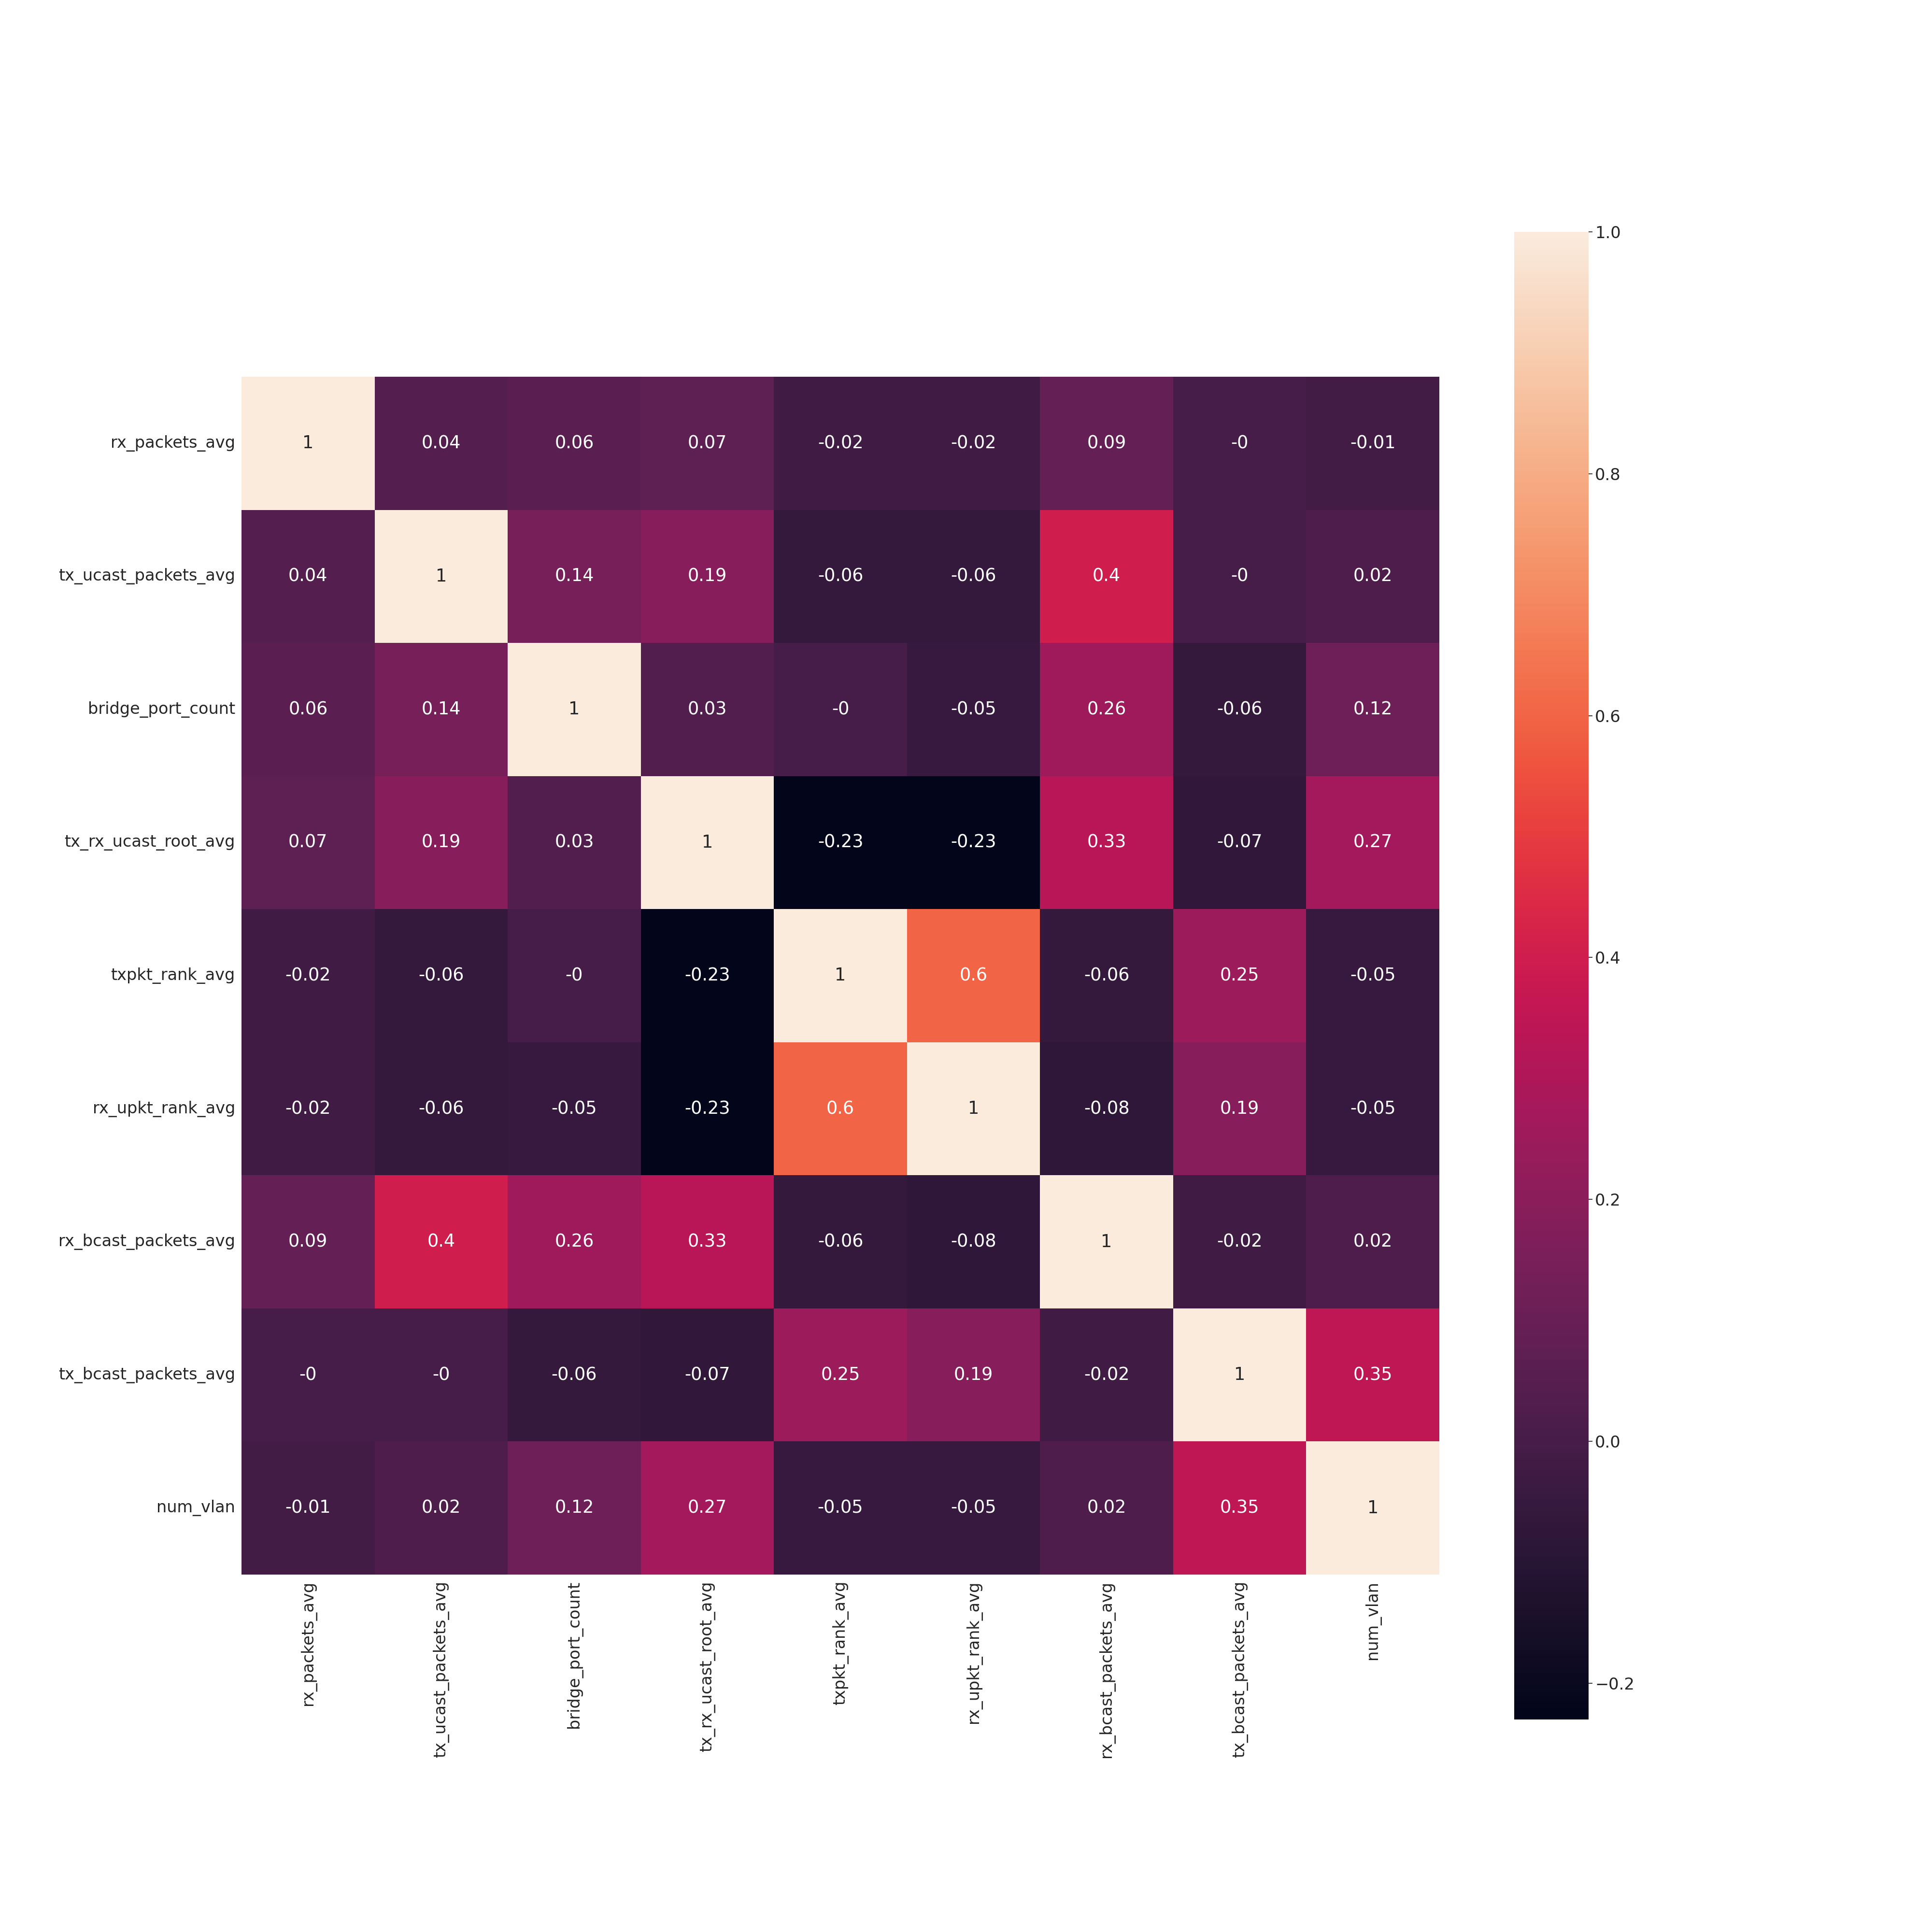

In [20]:
plt.clf()

Plot_Heatmap(df[Cont_cols])

%matplot plt

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Site based split

In [22]:
site_list = df["site_id"].unique().tolist()
train, test = train_test_split(site_list, test_size=0.3, random_state=111, shuffle=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
len(train), len(test), len(site_list)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(41, 18, 59)

In [24]:
df_train = df[df["site_id"].isin(train)].reset_index(drop=True)
df_train.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(114965, 49)

In [25]:
df_test = df[df["site_id"].isin(test)].reset_index(drop=True)
df_test.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(84859, 49)

In [26]:
df_train["label"].sum(), df_test["label"].sum()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(7900, 3652)

In [27]:
scaling_columns = [f for f in Cont_cols if ("root" not in f) and ("pct" not in f)]

Scaler = StandardScaler()
df_train.loc[:, scaling_columns] = Scaler.fit_transform(df_train.loc[:, scaling_columns])
df_test.loc[:, scaling_columns] = Scaler.transform(df_test.loc[:, scaling_columns])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
print("Missing Set: ", set(Cont_cols) - set(scaling_columns))
print("Extra Set: ", set(scaling_columns) - set(Cont_cols))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Missing Set:  {'tx_rx_ucast_root_avg'}
Extra Set:  set()

In [29]:
scaler_site = defaultdict(list)
mean_list = Scaler.mean_
std_list = Scaler.scale_
for i, col in enumerate(scaling_columns):
    scaler_site[col].append(mean_list[i])
    scaler_site[col].append(std_list[i])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
for k, v in scaler_site.items():
    print(k, ": ", v)
scaled_cols = scaler_site

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rx_packets_avg :  [694470.594191648, 8195686.776729621]
tx_ucast_packets_avg :  [62694.78502470797, 1033492.8308811807]
bridge_port_count :  [2.137343970429111, 3.0058833464809322]
txpkt_rank_avg :  [21.221940943802682, 22.868277543132905]
rx_upkt_rank_avg :  [27.74682636482497, 30.67872753684398]
rx_bcast_packets_avg :  [6133.404105248202, 60206.29674807401]
tx_bcast_packets_avg :  [29768.912004718633, 94925.90124482622]
num_vlan :  [3.5021441308224244, 8.734175118462634]

In [32]:
Cont_cols + cat_cols_list

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['rx_packets_avg', 'tx_ucast_packets_avg', 'bridge_port_count', 'tx_rx_ucast_root_avg', 'txpkt_rank_avg', 'rx_upkt_rank_avg', 'rx_bcast_packets_avg', 'tx_bcast_packets_avg', 'num_vlan', 'remotecap', 'rmbps', 'bridge']

#### RandomForest

In [33]:
#Testing RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth = 5, n_jobs = -1, random_state = 111)

clf.fit(df_train[Cont_cols+cat_cols_list], df_train["label"])
y_pred = clf.predict(df_test[Cont_cols+cat_cols_list])

print("Training Accuracy: ", accuracy_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list])), "Validation Accuracy: ", accuracy_score(df_test["label"], y_pred))
print("Training Precision: ", precision_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list])), "Validation Precision: ", precision_score(df_test["label"], y_pred))
print("Training Recall: ", recall_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list])), "Validation Recall: ", recall_score(df_test["label"], y_pred))
print("Training F1-Score: ", f1_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list])), "Validation F1-Score: ", f1_score(df_test["label"], y_pred))

y_predict_probas = clf.predict_proba(df_test[Cont_cols+cat_cols_list])[: , 1]

fpr, tpr, threshold = roc_curve(df_test["label"], y_predict_probas)
roc_auc = auc(fpr, tpr)

f1_max = 0
th_max = 0
for th in np.arange(0.3, 0.9, 0.05):
    f1 = f1_score(df_test["label"], (y_predict_probas>th).astype(int))
    if f1 >= f1_max:
        th_max = th
        f1_max = f1
    
print("Threshold: ", th_max, ", f1-score: ", f1_max)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Accuracy:  0.999808637411386 Validation Accuracy:  0.9983266359490449
Training Precision:  0.9972229235041656 Validation Precision:  0.9850746268656716
Training Recall:  1.0 Validation Recall:  0.9759036144578314
Training F1-Score:  0.9986095310327392 Validation F1-Score:  0.980467675378267
Threshold:  0.7 , f1-score:  0.9820837927232635

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

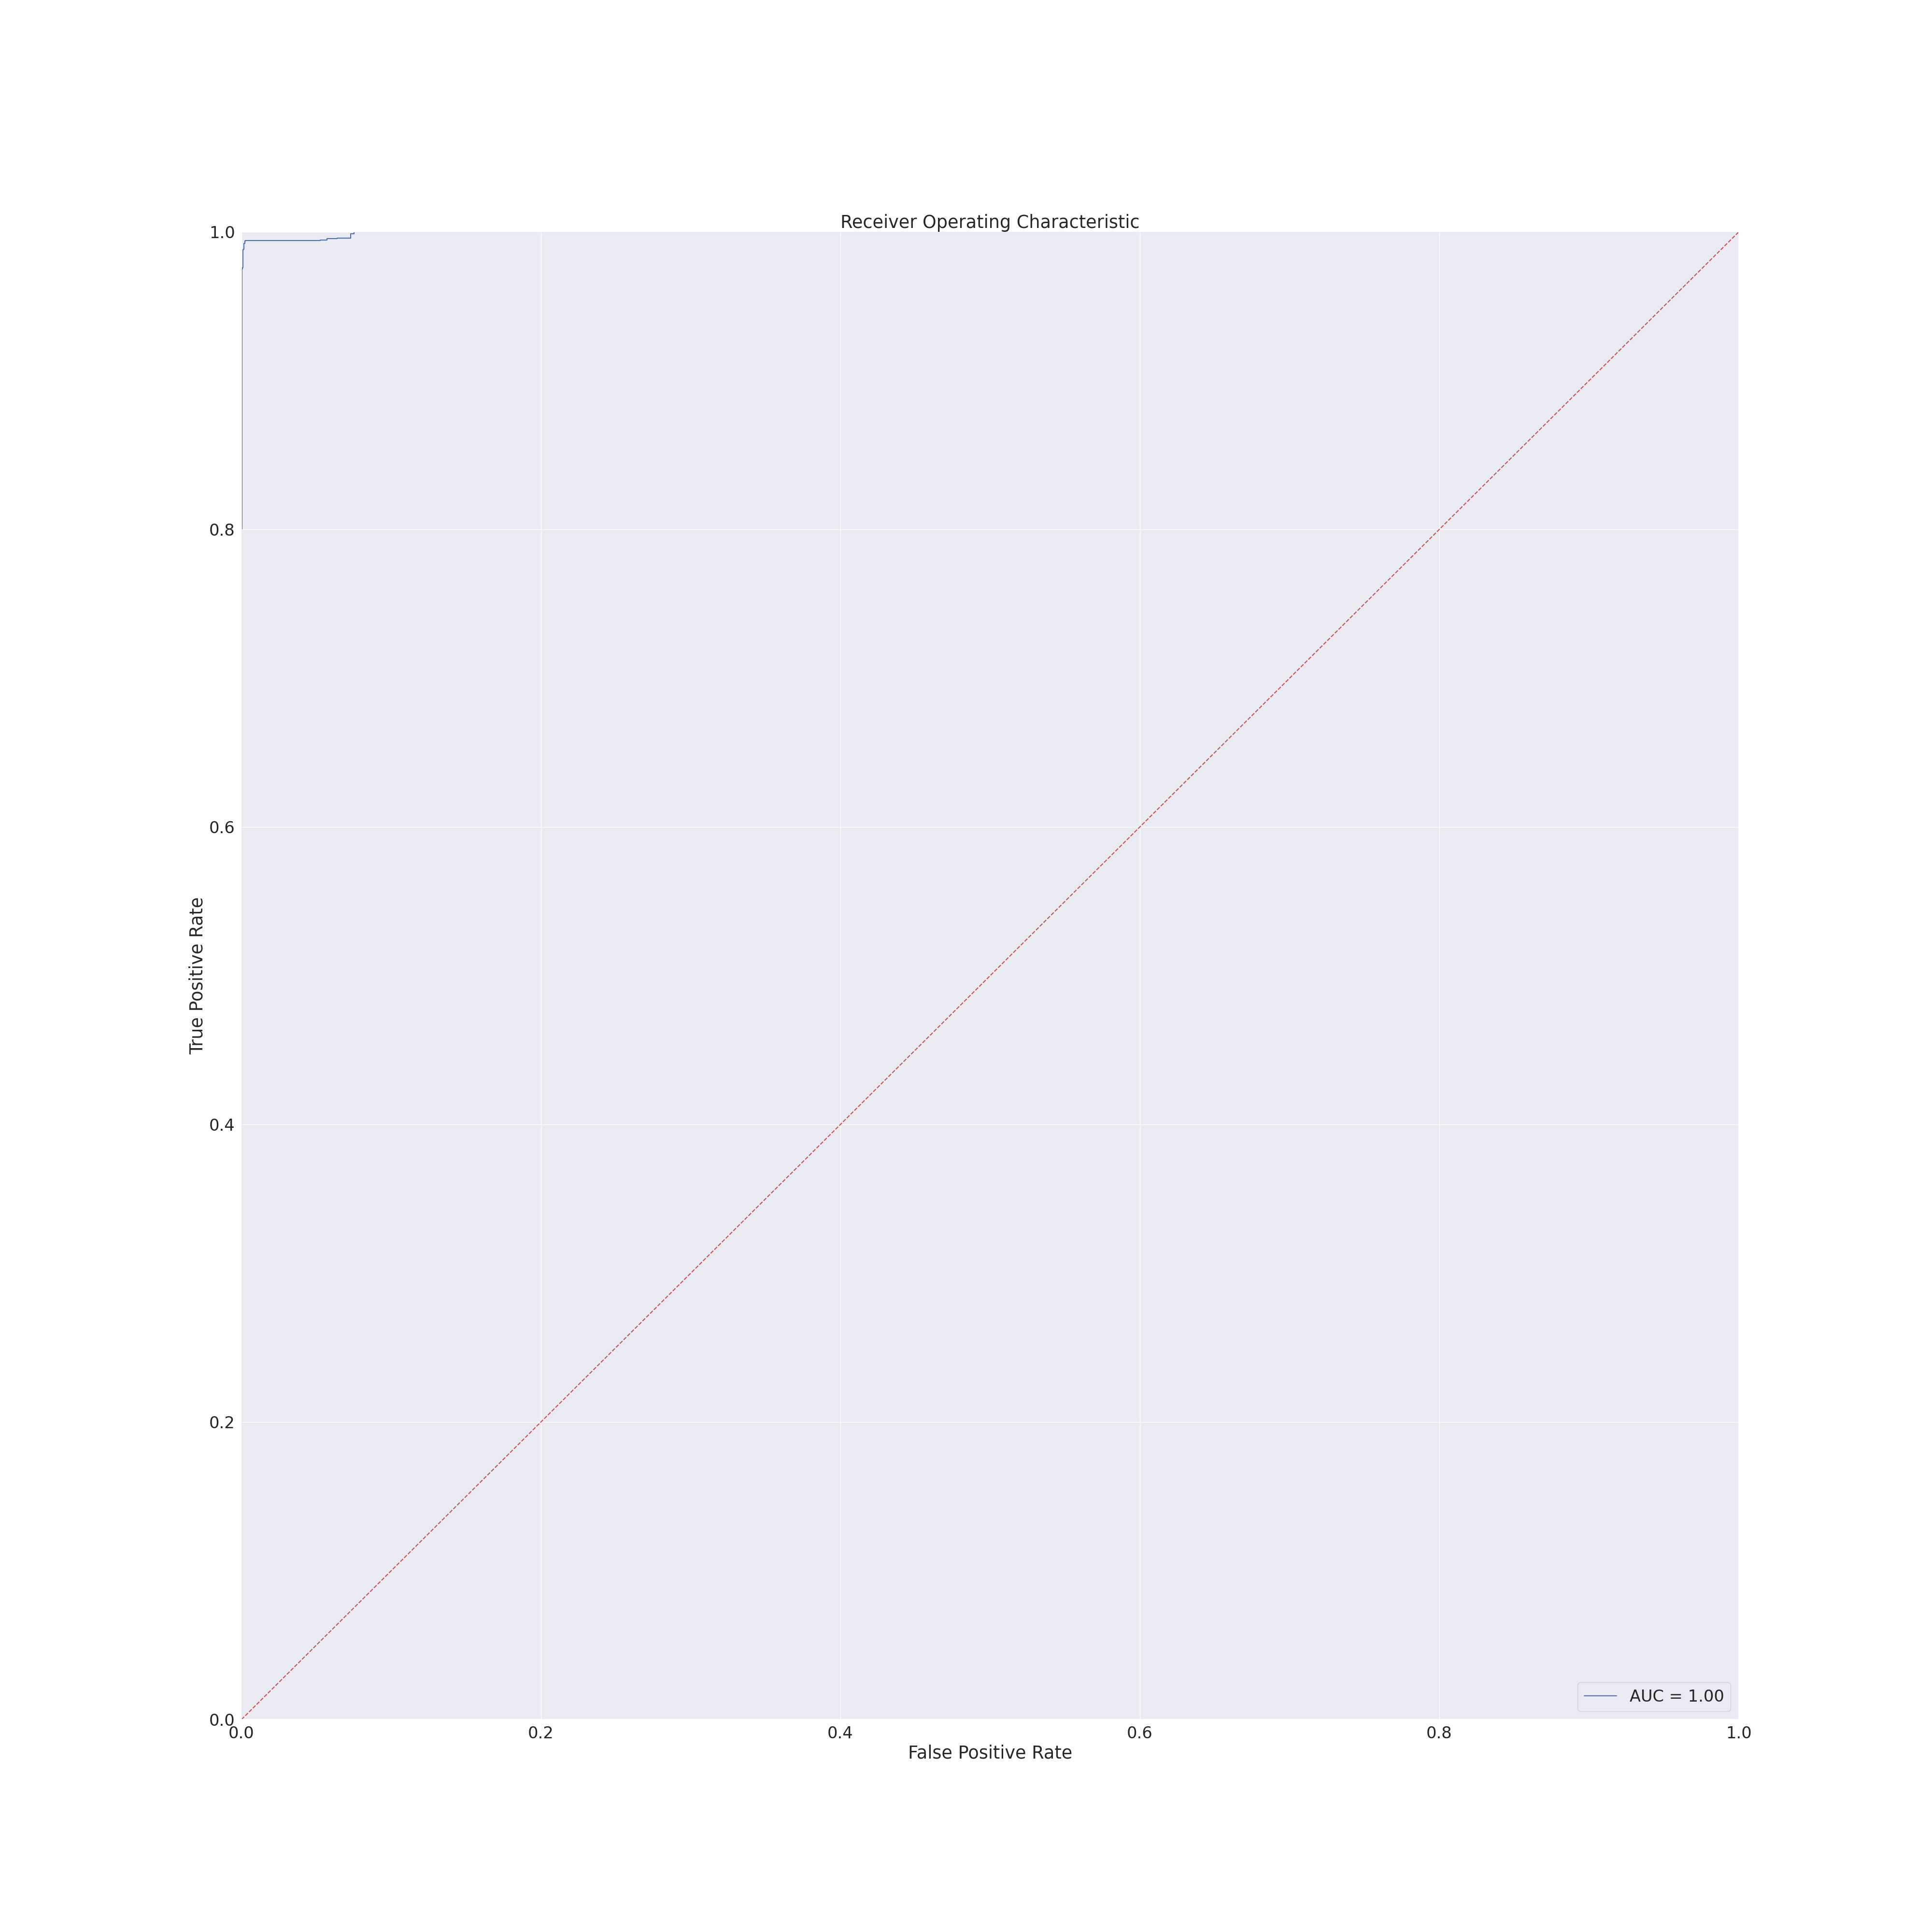

In [35]:
# Plotting ROC Curve
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

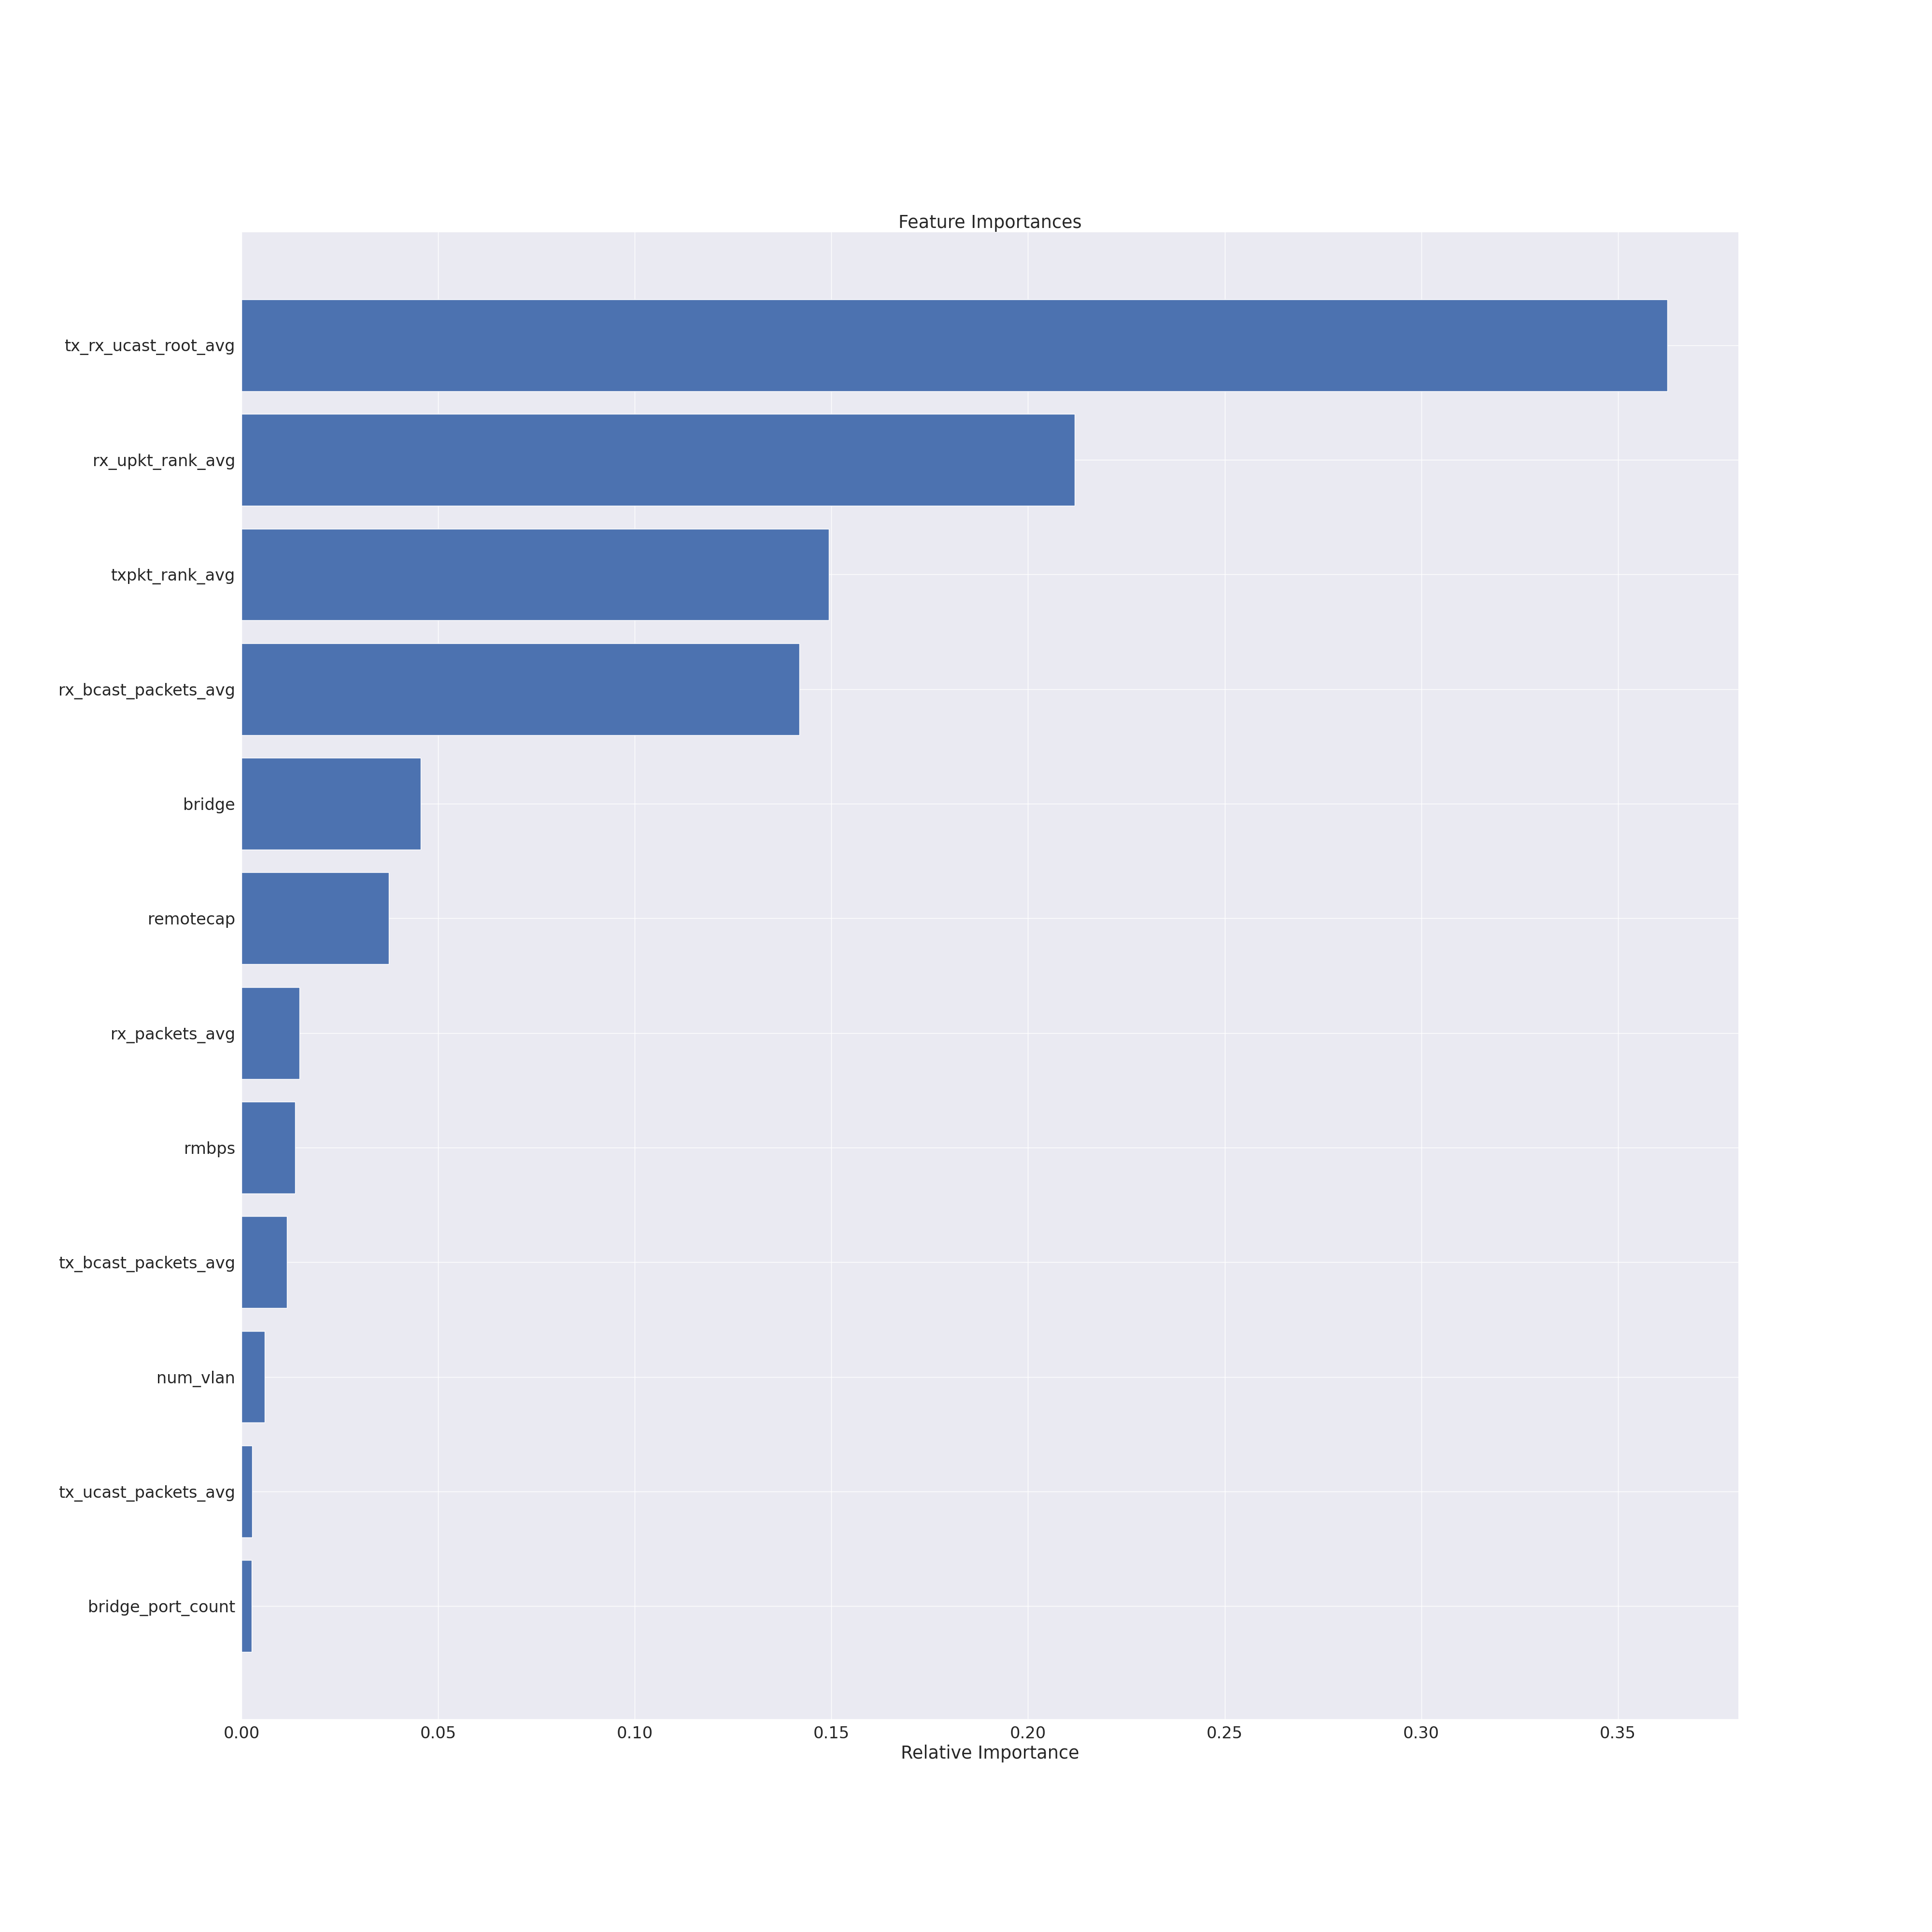

In [36]:
importances = clf.feature_importances_
indices = np.argsort(importances)
feature_cols = Cont_cols+cat_cols_list

plt.clf()
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

%matplot plt

In [37]:
for i in indices[::-1]:
    print(feature_cols[i], " : ", importances[i])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

tx_rx_ucast_root_avg  :  0.3626070507018565
rx_upkt_rank_avg  :  0.2118999421054129
txpkt_rank_avg  :  0.1493042908523533
rx_bcast_packets_avg  :  0.14191218781809925
bridge  :  0.045526450723061884
remotecap  :  0.03751866239081998
rx_packets_avg  :  0.014792188708045386
rmbps  :  0.01357669056248984
tx_bcast_packets_avg  :  0.01157445998545924
num_vlan  :  0.0059236550824025985
tx_ucast_packets_avg  :  0.0027577138509581565
bridge_port_count  :  0.00260670721904079

In [38]:
clf_rf_site = deepcopy(clf)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Stats

In [39]:
array_avg_expr = """aggregate(
    `{col}`,
    CAST(0.0 AS double),
    (acc, x) -> acc + x,
    acc -> acc / size(`{col}`))"""


coefficients = {
    "rx_upkt_rank_pct": 1.13479888631775, 
    "rxpkt_rank_pct": 0.9159373091067156, 
    "tx_upkt_rank_avg": -0.0648530562817491, 
    "rx_upkt_rank_avg": -0.05005964736708116, 
    "tx_ucast_root_avg": 2.135106024694902, 
    "rx_ucast_root_avg": 2.184482133981962, 
    "tx_upkt_rank_pct": 2.1912929006686626
  }
intercept = -2.4392463620817812
threshold = 0.35
b_threshold = 0.9

# features = ['events_count', 'rx_packets', 'rx_ucast_packets', 'tx_ucast_packets', 'bridge_port_count', 
#                    'tx_rx_ucast_root_avg', 'txpkt_rank_avg', 'rx_upkt_rank_avg', 'rx_mcast_packets', 'tx_mcast_packets', 
#                    'rx_bcast_packets', 'tx_bcast_packets', 'num_vlan', 'remotecap', 'rmbps', 'bridge', 'ae_port']
features = Cont_cols+cat_cols_list


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:

def set_max_uplinks_per_switch(df_uplink):
    b_threshold = 0.9
    max_uplinks_per_switch = 2
    if max_uplinks_per_switch >= 1:
        rank_window = Window().partitionBy(F.col('switch_id')).orderBy(
            F.col('uplink_prob_score').desc(), F.col('re_ix'), F.col('tx_rx_ucast_root_avg').desc())
        df_uplink = df_uplink.withColumn("uplink_score_rank", F.rank().over(rank_window)).withColumn(
            'uplink_value',
            F.when(((F.col("uplink_prob_score") < b_threshold) & (F.col("uplink_score_rank")>1)) | (F.col("uplink_score_rank") > max_uplinks_per_switch),
                   0).otherwise(F.col("uplink_value_threshold")))
    return df_uplink

def update_ae_port(df, df_uplink):
    rank_window = Window().partitionBy(F.col('switch_id')).orderBy(F.col("when").desc())
    df = df.withColumn("rank", F.rank().over(rank_window)).filter(F.col("rank")==1)
    df_ae = df.select("switch_id", F.explode("lldpneighbors").alias("l")) \
        .select("switch_id", "l.local_port_id", "l.local_parent_iface_name")
    df_ae = df_ae.filter(F.col("local_parent_iface_name").startswith("ae")) \
        .withColumn("ae_port", F.lit(1)) \
        .withColumnRenamed("local_port_id", "name")
    
    df_uplink = df_uplink.join(df_ae, ["switch_id", "name"], how="left")
    
    # New code for combining data for ae_ports
    df_ae_uplink = df_uplink.filter(F.col("ae_port")==1).groupBy(["switch_id", "when", "local_parent_iface_name"]).agg(
        F.sum('rx_packets').alias('rx_packets_ae'),
        F.sum('tx_packets').alias('tx_packets_ae'),
        F.sum('rx_bcast_packets').alias('rx_bcast_packets_ae'),
        F.sum('tx_bcast_packets').alias('tx_bcast_packets_ae'),
        F.sum('rx_ucast_packets').alias('rx_ucast_packets_ae'),
        F.sum('tx_ucast_packets').alias('tx_ucast_packets_ae'),
    )
    
    df_uplink = df_uplink.join(df_ae_uplink, ["switch_id", "when", "local_parent_iface_name"], how="left").drop("local_parent_iface_name")
    
    df_uplink = df_uplink.na.fill(value=0)

    data_cols = ['rx_packets', 'tx_packets', 'rx_bcast_packets', 
                 'tx_bcast_packets', 'tx_ucast_packets', 'rx_ucast_packets']
    for col in data_cols:
        df_uplink = df_uplink.withColumn(col, F.when(F.col("ae_port")==1, F.col(col+"_ae")).otherwise(F.col(col))).drop(col+"_ae")
    
    return df_uplink


def add_switch_level_features(df):
    df = df.withColumn('phy_ports_count', phy_count_udf(F.col('interfaces'), F.col('device_type'))) \
        .withColumn('active_phy_ports_count', active_phy_count_udf(F.col('interfaces'), F.col('device_type')))
    df = df.where('active_phy_ports_count>=1').withColumn('when', F.col('when') / 1000000)
    return df


def filter_zero_counters_records(df):
    df = df.withColumn('max_tx', F.array_max('interfaces.tx_packets')).withColumn(
        'max_rx', F.array_max('interfaces.rx_packets')).where('max_tx>0 or max_rx>0').drop('max_tx', 'max_rx')
    df = df.filter((F.col('delta')) & (F.col('delta_interval') > 0) & (F.col('switch_id') != "")
                   & (~F.col('model').startswith("SSR")))
    return df


def generate_interface_data(df):
    fields = ['switch_id', 'org_id', 'site_id', 'when', 'model', 'device_type', 'stpbridge_root_port']
    dfin = df.select(*fields, 'phy_ports_count', 'active_phy_ports_count', F.explode('interfaces').alias('interfaces')) \
        .select(*fields, 'phy_ports_count', 'active_phy_ports_count', F.col('interfaces.name').alias('name'),
                F.col('interfaces.link').alias('link'),
                F.col('interfaces.mbps').alias('mbps'),
                F.col('interfaces.admin_status').alias('admin_status'),
                F.col('interfaces.media_type').alias('media_type'),
                F.col('interfaces.remote_chassis_id').alias('remote_chassis_id'),  # remote port mac
                F.col('interfaces.remote_system_capability').alias('remote_system_capability'),
                F.col('interfaces.remote_hardware').alias('remote_hardware'),
                F.col('interfaces.vlan_ids').alias('vlan_ids'),
                F.col('interfaces.rx_packets').alias('rx_packets'),
                F.col('interfaces.tx_packets').alias('tx_packets'),
                F.col('interfaces.rx_bcast_packets').alias('rx_bcast_packets'),
                F.col('interfaces.tx_bcast_packets').alias('tx_bcast_packets'),
                F.col('interfaces.tx_ucast_packets').alias('tx_ucast_packets'),
                F.col('interfaces.rx_ucast_packets').alias('rx_ucast_packets'))
    dfin = dfin.withColumn('type', vp_udf(F.col('name'), F.col('media_type'), F.col('device_type')))
    dfin = dfin.filter((F.col('link')))
    dfin = dfin.filter(dfin.type == 'phy')
    dfin = dfin.withColumn('re_ix', reix_udf(dfin.name))
    return dfin


def add_derived_features(df):
    df_uplink = df.withColumn('remotecap', remotecap_udf(F.col('remote_system_capability'))) \
        .withColumn('rmbps', mbps_udf(F.col('mbps'))) \
        .withColumn('remotehw', remotehw_udf('remote_hardware')) \
        .withColumn('num_vlan', F.size('vlan_ids')) \
        .withColumn('bridge', bridge_udf(F.col('stpbridge_root_port'), F.col('name')))

    df_uplink = df_uplink.where('remotehw==1')  # Filter ports connected to AP
    df_uplink = add_record_level_features(df_uplink)
    return df_uplink


def add_record_level_features(df_uplink):
    w = Window.partitionBy(F.col('switch_id'), F.col('when'))
    df_uplink = df_uplink.withColumn(
        "rxpkt_rank",
        F.when(F.col('rx_packets') > 0, F.dense_rank().over(w.orderBy(F.col('rx_packets').desc()))).otherwise(
            100)).withColumn(
        "txpkt_rank",
        F.when(F.col('tx_packets') > 0, F.dense_rank().over(w.orderBy(F.col('tx_packets').desc()))).otherwise(
            100)).withColumn(
        "rx_upkt_rank", F.when(F.col('rx_ucast_packets') > 0,
                               F.dense_rank().over(w.orderBy(F.col('rx_ucast_packets').desc()))).otherwise(
            100)).withColumn(
        "tx_upkt_rank", F.when(F.col('tx_ucast_packets') > 0,
                               F.dense_rank().over(w.orderBy(F.col('tx_ucast_packets').desc()))).otherwise(
            100)).withColumn(
        "physical_port_count", F.count(F.col('switch_id')).over(w)).withColumn(
        "bridge_port_count", F.sum(F.col('remotecap')).over(w)).withColumn(
        'rx_packets_all', F.collect_list('rx_packets').over(w)).withColumn(
        'tx_packets_all', F.collect_list('tx_packets').over(w)).withColumn(
        'rx_ucast_packets_all', F.collect_list('rx_ucast_packets').over(w)).withColumn(
        'tx_ucast_packets_all', F.collect_list('tx_ucast_packets').over(w)).withColumn(
        'rx_root', is_root_udf('rx_packets', 'tx_packets', 'tx_packets_all')).withColumn(
        'tx_root', is_root_udf('tx_packets', 'rx_packets', 'rx_packets_all')).withColumn(
        'rx_ucast_root', is_root_udf('rx_ucast_packets', 'tx_ucast_packets', 'tx_ucast_packets_all')).withColumn(
        'tx_ucast_root', is_root_udf('tx_ucast_packets', 'rx_ucast_packets', 'rx_ucast_packets_all')).withColumn(
        'tx_rx_root', F.col('rx_root') * F.col('tx_root')).withColumn(
        'tx_rx_ucast_root', F.col('rx_ucast_root') * F.col('tx_ucast_root'))

    return df_uplink


def derive_rank_features(df):
    df_uplink = df.groupBy('org_id', 'site_id', 'switch_id', 'model', 'remote_chassis_id', 'device_type', 'name').agg(
        F.first('re_ix').alias('re_ix'),
        F.count('switch_id').alias('events_count'),
        F.max('remotecap').alias('remotecap'),
        F.max('rmbps').alias('rmbps'),
        F.max('bridge').alias('bridge'),
        F.max('num_vlan').alias('num_vlan'),
        F.sum('rx_packets').alias('rx_packets'),
        F.sum('tx_packets').alias('tx_packets'),
        F.sum('rx_bcast_packets').alias('rx_bcast_packets'),
        F.sum('tx_bcast_packets').alias('tx_bcast_packets'),
        F.sum('rx_ucast_packets').alias('rx_ucast_packets'),
        F.sum('tx_ucast_packets').alias('tx_ucast_packets'),
        F.collect_list('rxpkt_rank').alias("rxpkt_ranks"),
        F.collect_list('txpkt_rank').alias("txpkt_ranks"),
        F.collect_list('rx_upkt_rank').alias("rx_upkt_ranks"),
        F.collect_list('tx_upkt_rank').alias("tx_upkt_ranks"),
        F.avg('rxpkt_rank').alias("rxpkt_rank_avg"),
        F.avg('txpkt_rank').alias("txpkt_rank_avg"),
        F.avg('rx_upkt_rank').alias("rx_upkt_rank_avg"),
        F.avg('tx_upkt_rank').alias("tx_upkt_rank_avg"),
        F.avg('physical_port_count').alias("physical_port_count"),
        F.avg('bridge_port_count').alias("bridge_port_count"),
        F.avg('rx_root').alias("rx_root_avg"),
        F.avg('tx_root').alias("tx_root_avg"),
        F.avg('tx_rx_root').alias("tx_rx_root_avg"),
        F.avg('rx_ucast_root').alias("rx_ucast_root_avg"),
        F.avg('tx_ucast_root').alias("tx_ucast_root_avg"),
        F.avg('tx_rx_ucast_root').alias("tx_rx_ucast_root_avg")).withColumn(
        'rxpkt_rank_pct', get_rank_pct_udf(F.col('rxpkt_ranks'), F.col('events_count'))).withColumn(
        'txpkt_rank_pct', get_rank_pct_udf(F.col('txpkt_ranks'), F.col('events_count'))).withColumn(
        'rx_upkt_rank_pct', get_rank_pct_udf(F.col('rx_upkt_ranks'), F.col('events_count'))).withColumn(
        'tx_upkt_rank_pct', get_rank_pct_udf(F.col('tx_upkt_ranks'), F.col('events_count')))

    return df_uplink


@udf(returnType=IntegerType())
def phy_count_udf(interfaces, device_type):
    return len(
        [interface for interface in interfaces if
         get_port_type(interface['name'], interface['media_type'], device_type) == 'phy'])


@udf(returnType=IntegerType())
def active_phy_count_udf(interfaces, device_type):
    return len([interface for interface in interfaces if
                get_port_type(interface['name'], interface['media_type'], device_type) == 'phy' and is_config_port(
                    interface, device_type)])


def get_port_type(interface_name, media_type, device_type):
    name = interface_name if interface_name is not None else ''
    media = media_type if media_type is not None else ''
    device_type = device_type if device_type is not None else ''
    if device_type == 2:
        return 'phy' if len(name) >= 3 and (name[:2] == 'ge') | (name[:2] == 'xe') | (name[:2] == 'et') | (
                name[:2] == 're') else 'vir'
    elif media == 'copper' or media == 'fiber':
        return 'phy' if len(name) >= 3 and (name[:2] == 'ge') | (name[:2] == 'xe') | (name[:2] == 'et') | (
                name[:3] == 'mge') else 'vir'
    else:
        return 'vir'


def is_config_port(interface, device_type):
    # vlan_ids = interface['vlan_ids'] if interface['vlan_ids'] is not None else []
    # device_type = device_type if device_type is not None else ''
    # vlan_flag = len(vlan_ids) > 0
    # if device_type == 2:
    #     vlan_flag = True
    return (interface['link']) & (interface['admin_status']) & (not interface['unconfigured'])  #& vlan_flag


@udf(returnType=StringType())
def vp_udf(name, media_type, device_type):
    return get_port_type(name, media_type, device_type)


@udf(returnType=IntegerType())
def remotecap_udf(x):
    if (x == 'Bridge Router') or (x == 'Bridge'):
        return 1
    else:
        return 0


@udf(returnType=IntegerType())
def mbps_udf(x):
    if x > 1000:
        return 1
    else:
        return 0


@udf(returnType=IntegerType())
def remotehw_udf(x):
    if x is not None and len(x) >= 2 and x[:2] == 'AP':
        return 0
    else:
        return 1


@udf(returnType=IntegerType())
def bridge_udf(stpbridge_root_port, name):
    if stpbridge_root_port == name:
        return 1
    else:
        return 0


@udf(returnType=FloatType())
def get_rank_pct_udf(rank, event_count):
    return len([i for i in rank if i == 1]) / event_count


@udf(returnType=IntegerType())
def reix_udf(name):
    try:
        ix = name.split('-')[1].split('/')[0]
        if ix.isdigit():
            return int(ix)
    except IndexError:
        return 0
    return 0


@udf(returnType=IntegerType())
def is_root_udf(current, current_other, all_ports):
    if current == 0:
        return 0
    _all_others = all_ports
    if current_other > 0:
        _all_others = [t for t in all_ports if t != current_other]
    _max = 0
    if len(_all_others) > 0:
        _max = max(_all_others)
    if current > 0 and current >= _max:
        return 1
    else:
        return 0


@udf(returnType=FloatType())
def predict_uplink_udf(feature_values, coefficients, intercept):
    coef = np.array(coefficients)
    sigmoid_val = expit(np.dot(feature_values, coef.T) + intercept).ravel()
    return float(sigmoid_val[0])


@udf(returnType=FloatType())
def arrays_weighed_avg(avg_arr, events_arr):
    avg_arr = np.array(avg_arr)
    events_arr = np.array(events_arr)
    return float(np.sum(avg_arr * events_arr) / np.sum(events_arr))


@udf(returnType=FloatType())
def predict_new_uplink_udf(features):
    y_pred_rf = float(clf.predict_proba([features])[:, 1])
    return y_pred_rf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
def derive_avg_data_features(df, avg_data_cols_list):
    for col in avg_data_cols_list:
        df = df.withColumn(col+"_avg", F.col(col)/F.col("events_count"))
    
    return df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
def predict_new_prob(df, scaled_cols, features, coefficients, intercept, threshold, b_threshold):
    for k, v in scaled_cols.items():
        df = df.withColumn(k, (F.col(k) - F.lit(v[0]))/F.lit(v[1]))

    # event_threshold = (10 - scaled_cols["events_count"][0])/(scaled_cols["events_count"][1])
    event_threshold = 10
    df = df.withColumn('uplink_prob_score', F.when(F.col('events_count') >= event_threshold,
                                                   predict_new_uplink_udf(F.struct(*features))
                                                   ).otherwise(0.0)).withColumn(
        'uplink_value_threshold', F.when(F.col("uplink_prob_score") >= threshold, 1).otherwise(0))

    w = Window.partitionBy(F.col('switch_id'))
    df = df.withColumn('n_ind', F.max(F.col('uplink_value_threshold')).over(w))
    
    for k, v in scaled_cols.items():
        df = df.withColumn(k, (F.col(k)*F.lit(v[1])) + F.lit(v[0]))

    # Can be commented to stop mixing predictions
    b_features = []
    coef = []
    for k, v in coefficients.items():
        b_features.append(k)
        coef.append(float(v))
    df = df.withColumn('uplink_prob_score', F.when((F.col('events_count') >= 10)&(F.col("n_ind") == 0),
                                                   predict_uplink_udf(F.struct(*b_features),
                                                                      F.array([F.lit(x) for x in coef]),
                                                                      F.lit(intercept))
                                                   ).otherwise(F.col("uplink_prob_score"))).withColumn(
        'uplink_value_threshold', F.when((F.col('n_ind') == 0)&(F.col("uplink_prob_score") >= b_threshold), 1).otherwise(F.col("uplink_value_threshold")))
    
    return df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
date = '2022-08-19'
hr = '05'
hours = ['03', '04', '05']
env = 'production'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
def read_hourly_data(s3_path, hours):
    final_df = None
    for hr in hours:
        print('reading data for hr: {0}'.format(hr))
        _s3_path = s3_path.format(hr=hr)
        print('reading from s3')
        df = spark.read.parquet(_s3_path)
        print(df.count())
        if final_df is None:
            final_df = df
        else:
            _col1 = set(final_df.columns)
            _col2 = set(df.columns)
            for c in list(_col1.difference(_col2)):
                df = df.withColumn(c, psf.lit(''))
            for c in list(_col2.difference(_col1)):
                final_df = final_df.withColumn(c, psf.lit(''))
            final_df = final_df.unionByName(df)
    print('total records: {0}'.format(final_df.count()))
    return final_df

oc_stats_s3_path = 's3://mist-secorapp-'+env+'/oc-stats-analytics/oc-stats-analytics-'+env+'/dt='+date+'/hr={hr}/*'

df_hrs = read_hourly_data(oc_stats_s3_path, hours)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

reading data for hr: 03
reading from s3
386861
reading data for hr: 04
reading from s3
386691
reading data for hr: 05
reading from s3
386057
total records: 1159609

In [46]:
def new_rule(df_uplink, edges, nodes):
    nodes = nodes.withColumnRenamed("mac", "source").select("siteId", "source", "model", "deviceType").distinct()
    nodes = nodes.filter(~(psf.col("model")==""))
    
    edges = edges.join(nodes, ["siteId", "source"], how="left")
    edges = edges.withColumn("ap_ind", 
                         psf.when((psf.col("model").startswith("AP"))|(psf.col("deviceType") == "ap"), 
                                  1.0).otherwise(0.0))
    ap_info = edges.groupby("target").agg(psf.sum("ap_ind").alias("ap_count"))
    edges = edges.join(ap_info, ["target"], how="left").persist()
    
    edges = edges.withColumnRenamed("siteId", "site_id") \
        .withColumnRenamed("source", "switch_id") \
        .withColumnRenamed("sourcePort", "name")
    
    sel_cols = ["site_id", "switch_id", "name", "ap_count"]
    df_uplink = df_uplink.join(edges.select(*sel_cols).distinct(), ["site_id", "switch_id", "name"], 
                               how="left")
    return df_uplink

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
data_frame = filter_zero_counters_records(df=df_hrs)
data_frame = add_switch_level_features(data_frame)
df_uplink = generate_interface_data(data_frame)
df_uplink = update_ae_port(data_frame, df_uplink)
df_uplink = add_derived_features(df_uplink)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
df_uplink = derive_rank_features(df_uplink)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# saving first checkpoint

In [44]:
# Saving at local_path 
# uplink_pred_s3_path_pt_one = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/new_model_expts_9aug/part_one/"
uplink_pred_s3_path_pt_one = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/new_model_expts_19aug/part_one/"
# uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/model_preds_6apr/"

# df_uplink.repartition(1).write.parquet(uplink_pred_s3_path_pt_one, mode='overwrite')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
df_uplink = spark.read.parquet(uplink_pred_s3_path_pt_one)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [100]:
# Placeholder subsetting of data
# df_uplink = df_uplink.filter(F.col("site_id")=="6cf57059-af1c-4bac-a2cc-524144e3d5fc").persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
# Second Stricter Version
@udf(returnType=IntegerType())
def set_model_group(model):
    if model in ["EX2", "EX3"]:
        return 1
    elif model in ["EX4", "EX5", "EX9"]:
        return 2
    elif model in ["QFX", "VQF"]:
        return 3
    elif model in ["VSR", "SSR", "SRX"]:
        return 4
    else:
        return 0


@udf(returnType=IntegerType())
def select_candidate_port(model, remote_model, top_switch_model, top_model, num_top_model):
    if remote_model == 0:
        return 1
    elif model == top_model and num_top_model < 3:
        return 0
    elif remote_model > model:
        return 1
    elif remote_model == model:
        if remote_model == top_switch_model:
            return 1
        else:
            return 0
    else:
        return 0


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
def model_based_filtering(df_uplink):
    df_uplink = df_uplink.withColumn("model_type", F.substring("model", 1, 3))
    
    rank_window = Window().partitionBy(F.col('switch_id'), F.col('name')).orderBy(F.col("remote_chassis_id").desc())
    df_uplink = df_uplink.withColumn("rank", F.rank().over(rank_window)).filter(F.col("rank")==1)
    
    df_uplink = df_uplink.withColumn("model_group", set_model_group("model_type"))
    
    df_remote = df_uplink.select("site_id", "switch_id", "model_type", "model_group").distinct() \
    .withColumnRenamed("switch_id", "remote_chassis_id") \
    .withColumnRenamed("model_group", "remote_model_group") \
    .withColumnRenamed("model_type", "remote_model_type")
    
    df_uplink = df_uplink.join(df_remote, on=["site_id", "remote_chassis_id"], how="left") 
    
    site_window = Window().partitionBy(F.col('site_id'))
    df_remote = df_remote.withColumn("max_group", F.max("remote_model_group").over(site_window))
    
    df_remote_agg = df_remote.filter(F.col("remote_model_group") == F.col("max_group")).groupBy(["site_id"]).agg(
        F.max("max_group").alias("max_group"),
        F.countDistinct("remote_chassis_id").alias("num_top_dev")
    )
    
    df_uplink = df_uplink.join(df_remote_agg, on="site_id", how="left")
    
    df_uplink = df_uplink.fillna(0, subset=["remote_model_group"])
    
    switch_window = Window().partitionBy(F.col('switch_id'))
    df_uplink = df_uplink.withColumn("sw_max_group", F.max("remote_model_group").over(switch_window))
    
    df_uplink = df_uplink \
        .withColumn("candidate", select_candidate_port("model_group", "remote_model_group", "sw_max_group", 
                                                       "max_group", "num_top_dev"))
    df_uplink = df_uplink.filter(F.col("candidate")==1)
    
    return df_uplink
    

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
df_uplink = model_based_filtering(df_uplink)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
# Adding new function for getting avg of data columns
df_uplink = derive_avg_data_features(df_uplink, avg_data_cols_list)
df_uplink = predict_new_prob(df_uplink, scaled_cols, features, coefficients, intercept, threshold, b_threshold)
df_uplink = set_max_uplinks_per_switch(df_uplink)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Saved Uplink Model

In [3]:
# Saving at local_path 
# uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/new_model_expts_11may/"
# uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/new_model_expts_11may_old_logic/"
# uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/new_model_expts_11may_v3/"
# uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/new_model_expts_11may_v4/"
# uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/new_model_expts_11may_v5/"


# New Data to test
uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/new_model_expts_19aug/pt_two/"


# uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/model_preds_6apr/"

# df_uplink.repartition(1).write.parquet(uplink_pred_s3_path, mode='overwrite')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
df_uplink = spark.read.parquet(uplink_pred_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# 3d party devices low prob support only for top models in the site
df_uplink = df_uplink.withColumn("uplink_value", 
                                 F.when(((F.col("uplink_score_rank")==1)&(F.col("remote_model_group")==0)&(F.col("model_group")==F.col("max_group"))), 1).otherwise(F.col("uplink_value")))



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
df_uplink.filter((F.col("uplink_score_rank")==1)&(F.col("remote_model_group")==0)).select("switch_id").distinct().count()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12623

In [5]:
# 3d party devices low prob support only for top models in the site - 1803
df_uplink.filter((F.col("uplink_score_rank")==1)&(F.col("remote_model_group")==0)&(F.col("model_group")==F.col("max_group"))&(F.col("uplink_value")==0)).select("switch_id").distinct().count()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1803

In [6]:
# 1926
df_uplink.filter((F.col("uplink_score_rank")==1)&(F.col("remote_model_group")==0)&(F.col("uplink_value")==0)).select("switch_id").distinct().count()



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1926

In [35]:
df_uplink.filter(F.col("uplink_value")==1).select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

15136

In [40]:
df_uplink.filter((F.col("uplink_score_rank")==1)&(F.col("remote_model_group")==0)&(F.col("uplink_value")==0)).count()
                 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2388

In [20]:
switch_list = set(df_uplink.groupBy(["switch_id"]).agg(
    F.max("uplink_value").alias("uplink")
).filter(F.col("uplink") == 0).select("switch_id").toPandas()['switch_id'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
len(switch_list), len(existing_switch_list)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(2050, 1518)

In [22]:
len(switch_list & existing_switch_list)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1511

In [16]:
# Checking if it's the same as normal
uplink_path = 's3://mist-aggregated-stats-'+env+'/aggregated-stats/switch_uplink_model_v3/dt='+date+'/hr='+hr+'/last_3_hour/*'
df_check = spark.read.parquet(uplink_path)

existing_switch_list = set(df_check.groupBy(["switch_id"]).agg(
    F.max("uplink_value").alias("uplink")
).filter(F.col("uplink") == 0).select("switch_id").toPandas()['switch_id'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Loop Detection

In [10]:
from collections import defaultdict
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.types import BooleanType, ArrayType, StringType, IntegerType, MapType, FloatType, StructType, StructField


# import networkx as nx


class Cycles:
    def __init__(self, graph):
        self._graph = graph
        self.nodes = self.get_nodes()
        self.nodeMap = {node: i for i, node in enumerate(self.nodes)}
        self.visited = ['NOT_VISITED' for _ in range(len(self.nodes))]  # Initialize all nodes unvisited
        self.stack = []  # Stack to keep track of visited nodes
        self.cycles = []

    def get_nodes(self):
        _nodes = set([])
        for k, v in self._graph.items():
            items = [k] + v
            for item in items:
                _nodes.add(item)
        return list(_nodes)

    def print_cycles(self):
        return self.cycles

    def add_cycle(self, v):
        cycle = list()
        cycle.append(self.nodes[self.stack[-1]])
        i = 1
        while cycle[-1] != v and i < len(self.stack):
            i += 1
            cycle.append(self.nodes[self.stack[-i]])

        self.cycles.append(cycle)

    def dfs(self):
        curr = self.stack[-1]
        if self.nodes[curr] in self._graph:
            for neighbour in self._graph[self.nodes[curr]]:
                to = self.nodeMap[neighbour]
                if self.visited[to] == 'ON_STACK':
                    self.add_cycle(to)
                elif self.visited[to] == 'NOT_VISITED':
                    self.stack.append(to)
                    self.visited[to] = 'ON_STACK'
                    self.dfs()

        self.visited[curr] = 'DONE'
        self.stack.pop()

    def find_cycles(self):
        for i, node in enumerate(self.nodes):
            if self.visited[i] == 'NOT_VISITED':
                self.stack = []
                self.stack.append(i)
                self.visited[i] = 'ON_STACK'
                self.dfs()

        return self.print_cycles()


def get_site_graph(data_frame):
    df_site_adj_list = data_frame.select('siteId', 'src', 'dst') \
        .groupby('siteId', 'src') \
        .agg(F.collect_set(F.col('dst')).alias('dst'))
    df_site_adj_list = df_site_adj_list.groupby("siteId") \
        .agg(F.map_from_arrays(F.collect_list("src"), F.collect_list("dst")).alias("graph"))

    return df_site_adj_list


def _is_cycle(graph, v, done, stack):
    done[v] = True
    stack[v] = True

    for neighbour in graph[v]:
        if neighbour in graph:
            if not done[neighbour]:
                if _is_cycle(graph, neighbour, done, stack):
                    print(f'Part of cycle: {neighbour}')
                    return True
            elif stack[neighbour]:
                print(f'Last neighbour found on stack: {neighbour}')
                return True

    stack[v] = False
    return False


def is_cycle(graph):
    src_vertices = graph.keys()
    done = {k: False for k in src_vertices}
    stack = {k: False for k in src_vertices}

    for node in src_vertices:
        if not done[node]:
            if _is_cycle(graph, node, done, stack):
                return True
    return False


def find_cycles(graph):
    cycles = Cycles(graph)
    return cycles.find_cycles()


# def find_cycles_nx(graph):
#     G = nx.DiGraph(graph)
#     return list(nx.simple_cycles(G))
#
# udf_find_cycles_nx = F.udf(find_cycles_nx, ArrayType(ArrayType(StringType())))


# Added for site coverage caluclation
def reverse_graph(graph):
    k = graph.keys()
    v = graph.values()
    
    rev_graph = defaultdict(list)
    
    for key, value in zip(k, v):
        for val in value:
            rev_graph[val].append(key)
            
    return rev_graph


def _device_tag(graph, v, done):
    done[v] = True

    for neighbour in graph[v]:
        if neighbour in graph:
            if not done[neighbour]:
                _device_tag(graph, neighbour, done)
        else:
            done[neighbour] = True

    return None


def get_path(x):
    init_graph = x[0]
    df_sel_nodes = x[1]
    graph = reverse_graph(init_graph)
    src_vertices = graph.keys()
    
    target_vertices = []
    for values in graph.values():
        for val in values:
            target_vertices.append(val)
            
    vertices = set(src_vertices) | set(target_vertices)
    
    done = {k: False for k in vertices}

    source_macs = set([node.split("__")[0] for node in src_vertices])
    target_macs = set([node.split("__")[0] for node in init_graph.keys()])
    
    starting_nodes = source_macs - target_macs
    
    starting_vertices = [node for node in src_vertices if (node.split("__")[0] in starting_nodes)&(node.split("__")[0] in df_sel_nodes)]
    
    for node in starting_vertices:
        if not done[node]:
            _device_tag(graph, node, done)
    return done


udf_visit_count = F.udf(lambda x: len(set([device.split("__")[0] for device, visited in x.items() if visited == True])), IntegerType())

udf_node_count = F.udf(lambda x: len(set([device.split("__")[0] for device in x.keys()])), IntegerType())

udf_coverage = F.udf(lambda x: float(x[0])/float(x[1]), FloatType())
                                        
udf_get_path = F.udf(get_path, MapType(StringType(), BooleanType()))

udf_find_cycles = F.udf(find_cycles, ArrayType(ArrayType(StringType())))

udf_is_cycle = F.udf(is_cycle, BooleanType())

udf_array_size = F.udf(lambda a: [len(e) for e in a], ArrayType(IntegerType()))

udf_extract_mac = F.udf(lambda a: [s.split('__')[0] for lst in a for s in lst if '__' in s], ArrayType(StringType()))


uplink_match_schema = StructType([
    StructField("match", IntegerType()),  
    StructField("curr_mismatch", IntegerType()),
    StructField("pred_mismatch", IntegerType())
])

@F.udf(returnType=uplink_match_schema)
def uplink_match(uplink_curr, uplink_pred):
    if uplink_curr is None:
        if uplink_pred is None:
            return 0, 0, 0
        else:
            return 0, 0, len(uplink_pred)
    elif len(uplink_curr) == 0:
        if uplink_pred is None:
            return 0, 0, 0
        else:
            return 0, 0, len(uplink_pred)
    elif len(uplink_curr) > 0:
        if uplink_pred is None:
            return 0, len(uplink_curr), 0
        else:
            match = len(set(uplink_curr) & set(uplink_pred))
            curr_mismatch = len(uplink_curr) - match
            pred_mismatch = len(uplink_pred) - match
            return match, curr_mismatch, pred_mismatch



def compute(edges, nodes, df_oc, df_new_uplink):

#     df_oc = consistency_check(df_oc, df_new_uplink).persist()

#     old_preds_switches = df_oc.filter(F.size("uplink_combined")>0).count()
#     any_match = df_oc.filter((F.size("uplink_combined")>0)&(F.col("match")>0)).count()
#     total_match = df_oc.filter((F.size("uplink_combined")>0)&(F.col("match")>0)&(F.col("curr_mismatch")==0)&(F.col("pred_mismatch")==0)).count()
#     less_uplink_pred = df_oc.filter((F.size("uplink_combined")>0)&(F.col("match")>0)&(F.col("curr_mismatch")>0)&(F.col("pred_mismatch")==0)).count()
#     more_uplink_pred = df_oc.filter((F.size("uplink_combined")>0)&(F.col("match")>0)&(F.col("curr_mismatch")==0)&(F.col("pred_mismatch")>0)).count()
#     new_uplink_pred = df_oc.filter((~F.col("uplink_new").isNull()) & (F.size("uplink_combined")==0)).count()

#     no_uplink_pred = df_oc.filter((F.col("uplink_new").isNull()) & (F.size("uplink_combined")>0)).count()
#     diff_uplink_pred = df_oc.filter((~F.col("uplink_new").isNull()) & (F.size("uplink_combined")>0) & (F.col("match")==0)).count()
    
#     # Logging Consistency Metrics
#     print('Total switches with existing predictions : {}'.format(old_preds_switches))

#     print('Among existing, any match : {}'.format(any_match))

#     print('Among existing, total match : {}'.format(total_match))

#     print('Among existing, less uplinks predicted : {}'.format(less_uplink_pred))

#     print('Among existing, more uplinks predicted : {}'.format(more_uplink_pred))

#     print('New uplinks predicted : {}'.format(new_uplink_pred))
    
#     print('Among existing, no uplink predicted: {}'.format(no_uplink_pred))
    
#     print('Among existing, different uplink predicted: {}'.format(diff_uplink_pred))

    # Importing from old predictions where new predictions are unavailable
#     updated_edges = mix_predictions(df_oc, edges).persist()
    
    updated_edges = get_predictions(df_new_uplink, df_oc, edges).persist()

    active_edges, candidate_node = process_data(updated_edges, nodes)

    active_edges_count = active_edges.count()
    print('Total active_edges_count : {}'.format(active_edges_count))

    site_graph_cycle_true = get_sites_with_cycles(active_edges).persist()

    sites_with_cycles = site_graph_cycle_true.count()
    print('Sites with cycles in device collection(relType==uplink) = {}'.format(sites_with_cycles))

    # For site coverage
    df_cycle_cov = site_graph_cycle_true.join(candidate_node, 
                                    (site_graph_cycle_true.siteId == candidate_node.siteId_copy), 
                                    how="left").drop("siteId_copy")
    df_cov_stats = df_cycle_cov.withColumn("nodes_covered", 
                    udf_get_path(F.struct("graph", "mac_list"))) \
        .withColumn("visited_count", udf_visit_count(F.col("nodes_covered"))) \
        .withColumn("node_count", udf_node_count(F.col("nodes_covered"))) \
        .withColumn("coverage", udf_coverage(F.struct(F.col("visited_count"), F.col("node_count")))) \
        .select(*["siteId", "visited_count", "node_count", "coverage"]).persist()

    top_loop_count = df_cov_stats.filter(F.col("visited_count") == 0).count()
    print('Total sites with top level loops {}'.format(top_loop_count))
    
    stats = df_cov_stats.agg({"visited_count":"sum", "node_count": "sum", "coverage":"mean"}).collect()
    
    print("Stats Value: ", stats)
#     print('Coverage in sites with loops {}'.format(stats[0][0]))

#     print('Devices left out in sites with loops {}'.format(stats[0][2] - stats[0][1]))
    
    df_site_graph_all_cycles = site_graph_cycle_true.withColumn('cycles', udf_find_cycles(F.col('graph')))
    # df_site_graph_all_cycles_nx = site_graph_cycle_true.withColumn('cycles', udf_find_cycles_nx(F.col('graph')))
    # df_graph_cycles_nx_pd = df_site_graph_all_cycles_nx.select('siteId', 'cycles').toPandas()

    df_graph_cycles = df_site_graph_all_cycles \
        .select('siteId', 'cycles'). \
        withColumn('cycle_length', udf_array_size(F.col('cycles'))). \
        withColumn('num_cycles', F.size(F.col('cycle_length')))

    total_cycles = df_graph_cycles.select(
        F.sum(F.col('num_cycles')).alias('total_cycles')
    ).rdd.map(lambda x: x.asDict()).first()
    if total_cycles:
        print('new_model_total_cycles: ', total_cycles)

    df_device_macs = df_site_graph_all_cycles.select('siteId', 'cycles') \
        .withColumn('macs', udf_extract_mac(F.col('cycles')))
    df_macs = df_device_macs.select(F.explode(F.col('macs')).alias('mac')).distinct()

    total_device_count = df_macs.count()
    print('Total device involved in loops {}'.format(total_device_count))

    df_combined_nodes = df_macs.join(nodes, df_macs.mac == nodes.mac)

    device_types = df_combined_nodes.groupBy('deviceType') \
        .count().rdd.map(lambda x: x.asDict()).collect()
    device_types = {r.get('deviceType'): r.get('count') for r in device_types}
    if device_types:
        print('Total device_types {}'.format(device_types))
    
    return site_graph_cycle_true
    
def process_data(df_edges, df_nodes):
    """
    * Filter out deviceType=='ap'
    * create src, dst columns with mapping
        src-->(source,sourcePort)
        dst-->(target,targetPort)
    """
    print('Pre-processing node and edge data')
    df_edges = df_edges.withColumn('isExpired', F.when(F.isnull(F.col('expiredAt')), 'False').otherwise('True'))
    df_active_edges = df_edges.filter(F.col('isExpired') == F.lit(False))
    df_active_edges = df_active_edges.filter(F.col('relType') == 'uplink')

    df_nodes = df_nodes.withColumn('isExpired', F.when(F.isnull(F.col('expiredAt')), 'False').otherwise('True'))
    df_active_nodes = df_nodes.filter(F.col('isExpired') == F.lit(False))
    df_active_nodes = df_active_nodes.withColumnRenamed("siteId", "siteId_copy")

    # For site coverage
    candidate_node = df_active_nodes.filter(F.col("deviceType").isin(['switch', 'gateway', 'third'])) \
        .where(F.col("model") != 'SSR') \
        .where(~((F.isnull(F.col("mac")))|(F.col("mac")==''))) \
        .select(*["siteId_copy", "mac", "deviceType"]).distinct() \

    candidate_node = candidate_node.groupby(F.col("siteId_copy")).agg(F.collect_list(F.col("mac")).alias("mac_list"))

    df_join = df_active_edges.join(df_active_nodes, [df_active_edges.source == df_active_nodes.mac,
                                                     df_active_edges.siteId == df_active_nodes.siteId_copy]) \
        .drop('siteId_copy')

    df_active_nodes = df_active_nodes.withColumn('mac_target', df_active_nodes.mac) \
        .withColumn('deviceType_target', df_active_nodes.deviceType)

    df_join = df_join.join(df_active_nodes.select('mac_target', 'deviceType_target', 'siteId_copy'),
                           [df_join.target == df_active_nodes.mac_target,
                            df_join.siteId == df_active_nodes.siteId_copy])

    df_active_edges_filtered = df_join.filter((F.col('deviceType') != 'ap') & (F.col('deviceType_target') != 'ap')) \
        .select('siteId', 'source', 'target', 'sourcePort', 'targetPort', 'sourceVendor', 'targetVendor',
                'deviceType',
                'deviceType_target', 'relType')

    df_active_edges_filtered = df_active_edges_filtered.withColumn('src', F.concat_ws("__", F.col('source'),
                                                                                      F.col('sourcePort'))) \
        .withColumn('dst', F.concat_ws("__", F.col('target'), F.col('targetPort')))

    return df_active_edges_filtered, candidate_node

def get_sites_with_cycles(data_frame):
    print('Building graph in get_sites_with_cycles')
    df_site_graph = get_site_graph(data_frame)
    df_site_graph_cycle = df_site_graph.withColumn('cycle_detected', udf_is_cycle(F.col('graph')))
    return df_site_graph_cycle.filter(F.col('cycle_detected') == F.lit(True))

def consistency_check(df_oc, df_new):
    df_new = df_new.filter((F.col("uplink_value")==1) & (F.col("n_ind")==1)).groupby("site_id", "switch_id").agg(
        F.collect_list("name").alias("uplink_new")
    )

    rank_window = Window().partitionBy(F.col('switch_id')).orderBy(F.col("when").desc())
    df_oc = df_oc.withColumn("rank", F.rank().over(rank_window)).filter(F.col("rank")==1)
    df_oc = df_oc.select("site_id", "switch_id", "uplink_combined")

    df_oc = df_oc.join(df_new, ["site_id", "switch_id"], how="outer")
    df_oc = df_oc.withColumn("match", uplink_match("uplink_combined", "uplink_new")) \
        .select('site_id', 'switch_id', 'uplink_combined', 'uplink_new', F.col('match.*'))

    return df_oc

def mix_predictions(df, df_edges):
    df = df.withColumn("mixed_uplink", F.when(F.col("uplink_new").isNull(), 
        F.col("uplink_combined")).otherwise(F.col("uplink_new")))

    df = df.select('site_id', 'switch_id', F.explode('mixed_uplink').alias("name")) \
        .withColumn("uplink_value", F.lit(1)).persist()

    df = df.withColumnRenamed("site_id", "siteId") \
        .withColumnRenamed("switch_id", "source") \
        .withColumnRenamed("name", "sourcePort")

    df_edges = df_edges.join(df, ["siteId", "source", "sourcePort"], how="left")
    df_edges = df_edges.drop("relType")
    df_edges = df_edges.withColumn("relType", F.when(F.col("uplink_value") == 1, 'uplink').otherwise(''))
    return df_edges

# New Code
def add_heuristic(df_new, df_oc):
#     df_new = df_new.filter(F.col("uplink_value")==1).groupby("site_id", "switch_id").agg(
#         F.collect_list("name").alias("uplink_new")
#     )
    df_new = df_new.filter(F.col("uplink_value")==1).groupby("site_id", "switch_id", "n_ind").agg(
        F.collect_list("name").alias("uplink_new")
    )

    rank_window = Window().partitionBy(F.col('switch_id')).orderBy(F.col("when").desc())
    df_oc = df_oc.withColumn("rank", F.rank().over(rank_window)).filter(F.col("rank")==1)
    df_oc = df_oc.select("site_id", "switch_id", "uplink_heuristic")

    df_oc = df_oc.join(df_new, ["site_id", "switch_id"], how="outer")
    
#     df_oc = df_oc.withColumn("uplink_combined", F.when(F.col("uplink_new").isNull(), F.col("uplink_heuristic")).otherwise(F.col("uplink_new")))
    df_oc = df_oc.withColumn("uplink_combined", F.when((F.col("uplink_new").isNull())|((F.col("n_ind")==0)&(F.size("uplink_heuristic")>0)), F.col("uplink_heuristic")).otherwise(F.col("uplink_new")))

    
    df = df_oc.select('site_id', 'switch_id', F.explode('uplink_combined').alias("name")) \
        .withColumn("uplink_value", F.lit(1)).persist()
    
    return df

def get_predictions(df, df_oc, df_edges):
    df = add_heuristic(df, df_oc)

    df = df.withColumnRenamed("site_id", "siteId") \
        .withColumnRenamed("switch_id", "source") \
        .withColumnRenamed("name", "sourcePort")

    df_edges = df_edges.join(df, ["siteId", "source", "sourcePort"], how="left")
    df_edges = df_edges.drop("relType")
    df_edges = df_edges.withColumn("relType", F.when(F.col("uplink_value") == 1, 'uplink').otherwise(''))
    return df_edges

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
s3_path = 's3://mist-aggregated-stats-'+env+'/aggregated-stats/graph/snapshots/device-edges/dt='+date+'/hr='+hr+'/*'
node_s3_path = 's3://mist-aggregated-stats-'+env+'/aggregated-stats/graph/snapshots/device-nodes/dt='+date+'/hr='+hr+'/*'
oc_stats_s3_path = 's3://mist-secorapp-'+env+'/oc-stats-analytics/oc-stats-analytics-'+env+'/dt='+date+'/hr='+hr+'/*'

print(s3_path)
print(node_s3_path)
print(oc_stats_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://mist-aggregated-stats-production/aggregated-stats/graph/snapshots/device-edges/dt=2022-08-19/hr=05/*
s3://mist-aggregated-stats-production/aggregated-stats/graph/snapshots/device-nodes/dt=2022-08-19/hr=05/*
s3://mist-secorapp-production/oc-stats-analytics/oc-stats-analytics-production/dt=2022-08-19/hr=05/*

In [12]:
print('reading from s3')
df_edge = spark.read.parquet(s3_path)
df_node = spark.read.parquet(node_s3_path)
df_oc_stat = spark.read.parquet(oc_stats_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

reading from s3

In [10]:
# With new, correct logic and 3rd party low prob support - edges - 17034 (43, 32) 
# With new, correct logic only - edges - 16072 (45, 34)
# With new, correct logic and top 2 devices - 3rd party low prob support - edges - 16866 (30, 19) 
# With new, correct logic and top 2 devices only - edges - 15632 (36, 25)
# With new, correct logic and top 2 devices - 3rd party low prob support for only top models - edges - 16686 (30, 19)
# With new, correct logic and top 2 devices - 3rd party low prob support for only top models - edges - 17257 (32, 21)

sites = compute(df_edge, df_node, df_oc_stat, df_uplink)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Pre-processing node and edge data
Total active_edges_count : 17257
Building graph in get_sites_with_cycles
Sites with cycles in device collection(relType==uplink) = 32
Total sites with top level loops 21
Stats Value:  [Row(avg(coverage)=0.15698360884562135, sum(visited_count)=80, sum(node_count)=319)]
new_model_total_cycles:  {'total_cycles': 35}
Total device involved in loops 67
Total device_types {'gateway': 1, 'switch': 66}

In [11]:
site_list = set(sites.select("siteId").toPandas()["siteId"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df_oc_stat.select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

19338

In [13]:
site_agg = df_oc_stat.filter(F.col("site_id").isin(site_list)).groupBy(["site_id"]).agg(
    F.countDistinct("switch_id").alias("switch_count")
).sort(F.desc("switch_count"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
site_agg.show(50, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------+------------+
|site_id                             |switch_count|
+------------------------------------+------------+
|8e443f2e-914e-43fc-91e6-0d732c82d610|52          |
|061f9433-7f3a-44f0-8344-542a2e373f62|27          |
|75ac695f-3735-4623-b6a1-41836a067b2d|24          |
|99becb91-9980-4653-83f0-7a222bad655c|17          |
|ec462ddc-312d-4ffc-8b18-258066209d47|14          |
|1645f666-d2c8-4574-a300-b52d49ce4167|14          |
|20f8ab3e-2bc9-4be3-ac1a-ad89dc28f643|13          |
|10448f99-05ff-423f-b48e-696413d4c019|11          |
|37d7d338-2222-4474-8a73-c9c3f67517bf|11          |
|60a31a89-4a68-4a46-a58e-0a8cf866ef7a|11          |
|38ca4749-cf30-4039-9bd8-7deca94c791f|10          |
|52677f6a-c52a-4a76-9dc6-301203617461|8           |
|525edbfb-428c-43ca-a07c-23d50090022c|8           |
|7e86e1cc-e584-43d5-98a8-1f4e718254fb|8           |
|8aaac023-5c5b-4431-85cb-1465b7168d91|6           |
|b011800e-1a35-475c-8e42-250c1cac6f39|6           |
|58520b3b-93